# Aiida

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.shared import get_dict, get_list

from aiida import load_profile, orm

load_profile()

workflow_json_filename = "aiida_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph

In [3]:
from example_workflows.quantum_espresso.quantum_espresso_workflow import generate_structures
from example_workflows.quantum_espresso.quantum_espresso_workflow import get_bulk_structure
from example_workflows.quantum_espresso.quantum_espresso_workflow import calculate_qe as _calculate_qe
from example_workflows.quantum_espresso.quantum_espresso_workflow import plot_energy_volume_curve

In [4]:
calculate_qe = task(outputs=["energy", "volume", "structure"])(_calculate_qe)

In [5]:
wg = WorkGraph("wg-qe")

### Prepare the inputs

In [6]:
element = orm.Str("Al")
a = orm.Float(4.04)
cubic = orm.Bool(True)
relax_workdir = orm.Str("mini")
pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
kpts = orm.List([3, 3, 3])
calc_type_relax = orm.Str("vc-relax")
calc_type_scf = orm.Str("scf")
smearing = orm.Float(0.02)
strain_lst = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])

### Actual tasks to construct the EOS workflow

In [7]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    element=element,
    a=a,
    cubic=cubic,
)

In [8]:
relax_prepare_input_dict_task = wg.add_task(
    get_dict,
    name="relax_get_dict",
    structure=get_bulk_structure_task.outputs.result,
    calculation=calc_type_relax,
    kpts=kpts,
    pseudopotentials=pseudopotentials,
    smearing=smearing,
)

relax_task = wg.add_task(
    calculate_qe,
    name="mini",
    input_dict=relax_prepare_input_dict_task.outputs.result,
    working_directory=relax_workdir,
)

In [9]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    structure=relax_task.outputs.structure,
    strain_lst=strain_lst,
)

In [10]:
get_volumes_task = wg.add_task(get_list, name="get_volumes")

In [11]:
get_energies_task = wg.add_task(get_list, name="get_energies")

In [12]:
strain_dir_tasks, scf_qe_tasks, scf_get_dict_tasks = [], [], []

for i, strain in enumerate(strain_lst):

    structure_key = f"s_{i}"
    strain_dir = orm.Str(f"strain_{i}")
    generate_structures_task.add_output("workgraph.any", structure_key)

    scf_prepare_input_dict_task = wg.add_task(
        get_dict,
        name=f"get_dict_{i}",
        structure=generate_structures_task.outputs[structure_key],
        calculation=calc_type_scf,
        kpts=kpts,
        pseudopotentials=pseudopotentials,
        smearing=smearing,
    )

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        input_dict=scf_prepare_input_dict_task.outputs.result,
        working_directory=strain_dir,
    )

    # collect energy and volume
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [13]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    volume_lst=get_volumes_task.outputs.result,
    energy_lst=get_energies_task.outputs.result,
)

In [14]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [15]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [16]:
!cat {workflow_json_filename}

{
  "nodes": [
    {
      "id": 0,
      "function": "quantum_espresso_workflow.get_bulk_structure"
    },
    {
      "id": 1,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 2,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 3,
      "function": "quantum_espresso_workflow.generate_structures"
    },
    {
      "id": 4,
      "function": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 5,
      "function": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 6,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 7,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 8,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 9,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 10,
      "function": "python_workflow_definition.shared.get_dic

## Load Workflow with jobflow

In [17]:
from python_workflow_definition.jobflow import load_workflow_json

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [18]:
from jobflow.managers.local import run_locally

In [19]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [20]:
flow[0].function_kwargs["a"] = 4.05

2025-04-23 09:31:18,763 INFO Started executing jobs locally
2025-04-23 09:31:19,023 INFO Starting job - get_bulk_structure (ceb203d4-4b50-4fbf-bd60-36680543382b)
2025-04-23 09:31:19,030 INFO Finished job - get_bulk_structure (ceb203d4-4b50-4fbf-bd60-36680543382b)
2025-04-23 09:31:19,031 INFO Starting job - get_dict (27f28719-6394-4a85-b93f-c8ece2feceaf)
2025-04-23 09:31:19,034 INFO Finished job - get_dict (27f28719-6394-4a85-b93f-c8ece2feceaf)
2025-04-23 09:31:19,035 INFO Starting job - calculate_qe (ae0b4b06-5734-41ea-a7cc-e8393ef01e55)


[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01795] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-23 09:32:12,183 INFO Finished job - calculate_qe (ae0b4b06-5734-41ea-a7cc-e8393ef01e55)
2025-04-23 09:32:12,184 INFO Starting job - generate_structures (e9deb2a2-2e2a-4077-a221-a6afc9701377)
2025-04-23 09:32:12,189 INFO Finished job - generate_structures (e9deb2a2-2e2a-4077-a221-a6afc9701377)
2025-04-23 09:32:12,189 INFO Starting job - get_dict (9f4a0c82-798c-4178-9a46-c5430a2853c1)
2025-04-23 09:32:12,190 INFO Finished job - get_dict (9f4a0c82-798c-4178-9a46-c5430a2853c1)
2025-04-23 09:32:12,191 INFO Starting job - get_dict (8e10ca3a-91ba-4647-bca8-3c905020fb39)
2025-04-23 09:32:12,192 INFO Finished job - get_dict (8e10ca3a-91ba-4647-bca8-3c905020fb39)
2025-04-23 09:32:12,193 INFO Starting job - get_dict (765da827-3180-44d3-940e-e9d5a7e2ae45)
2025-04-23 09:32:12,194 INFO Finished job - get_dict (765da827-3180-44d3-940e-e9d5a7e2ae45)
2025-04-23 09:32:12,195 INFO Starting job - get_dict (5f8ce3d7-f65e-481d-8cb0-291d204df659)
2025-04-23 09:32:12,196 INFO Finished job - get_dict (

[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01814] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-23 09:32:23,091 INFO Finished job - calculate_qe (282ce127-dc4e-4e2d-9769-c22bdcdf2e3f)
2025-04-23 09:32:23,092 INFO Starting job - calculate_qe (76b1d287-fd0f-4fed-a0b7-cc817dffe2d8)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01825] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-23 09:32:34,038 INFO Finished job - calculate_qe (76b1d287-fd0f-4fed-a0b7-cc817dffe2d8)
2025-04-23 09:32:34,038 INFO Starting job - calculate_qe (2c6bfb73-15c3-4be7-95ab-f9afbeaf53bc)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01836] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-23 09:32:46,472 INFO Finished job - calculate_qe (2c6bfb73-15c3-4be7-95ab-f9afbeaf53bc)
2025-04-23 09:32:46,473 INFO Starting job - calculate_qe (4f947882-06db-4296-8456-b12cff2e66e3)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01847] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-23 09:33:00,409 INFO Finished job - calculate_qe (4f947882-06db-4296-8456-b12cff2e66e3)
2025-04-23 09:33:00,410 INFO Starting job - calculate_qe (d7bd31df-d3a7-49a1-9ae8-7766d4c519ec)


[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01858] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-23 09:33:14,798 INFO Finished job - calculate_qe (d7bd31df-d3a7-49a1-9ae8-7766d4c519ec)
2025-04-23 09:33:14,800 INFO Starting job - get_list (daa806da-16e9-4733-afe1-2ae60dc6292f)
2025-04-23 09:33:14,804 INFO Finished job - get_list (daa806da-16e9-4733-afe1-2ae60dc6292f)
2025-04-23 09:33:14,805 INFO Starting job - get_list (407d4cb0-b4f3-41f5-ba66-077754af69eb)
2025-04-23 09:33:14,808 INFO Finished job - get_list (407d4cb0-b4f3-41f5-ba66-077754af69eb)
2025-04-23 09:33:14,810 INFO Starting job - plot_energy_volume_curve (e363e583-bcc3-4cd8-b943-f6e4487b11f0)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-23 09:33:14,912 INFO Finished job - plot_energy_volume_curve (e363e583-bcc3-4cd8-b943-f6e4487b11f0)
2025-04-23 09:33:14,913 INFO Finished executing jobs locally


{'ceb203d4-4b50-4fbf-bd60-36680543382b': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

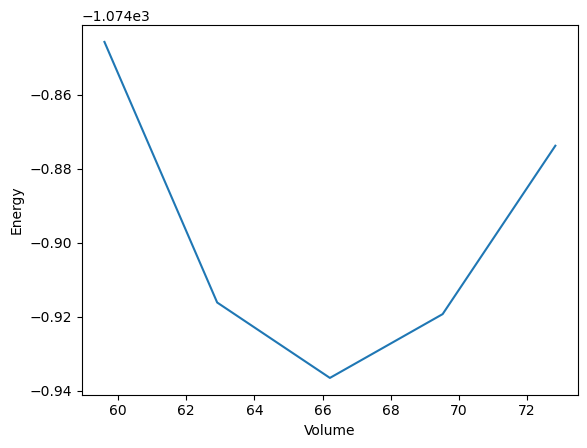

In [21]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

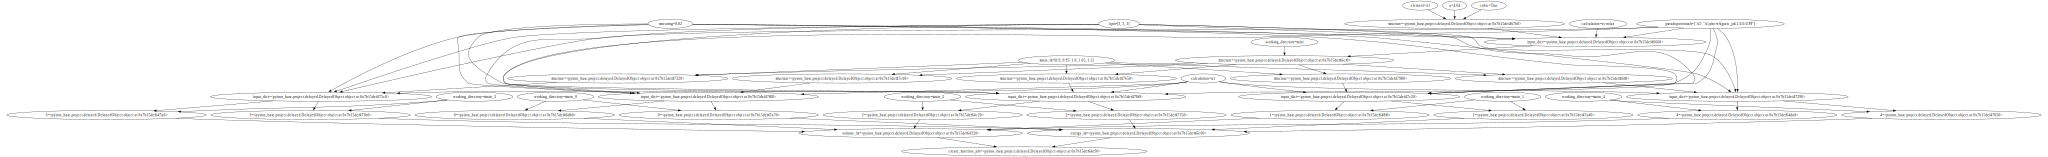

In [23]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [24]:
delayed_object_lst[0].input['a'] = 4.05

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 1
The job get_dict_20400c1655d51731f9f5ffb50c2b401f was saved and received the ID: 2
The job calculate_qe_22b5d0934d89d8f08761e744e4612c30 was saved and received the ID: 3


[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01892] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_6bbb6b6ae566b035388bec7f6f658394 was saved and received the ID: 4
The job get_dict_7fbef1423a72155d480420469f6f0f78 was saved and received the ID: 5
The job calculate_qe_35d4282b6beff7c2fc7a850e02ff3f07 was saved and received the ID: 6


[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01908] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_bcd13fb93bbd4d7a7a99c460c0591b51 was saved and received the ID: 7
The job calculate_qe_3159d3281f1fccbf1a91388144a7957f was saved and received the ID: 8


[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01919] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_5b1eeb4af2f8eb4018b7326f4af63eca was saved and received the ID: 9
The job calculate_qe_4d1c131dceca1e8897f7cda47cb24f9e was saved and received the ID: 10


[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01930] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_566acb6c9830b82fd09efc4e8227e6e6 was saved and received the ID: 11
The job calculate_qe_e463d009aee35caa551669d8efc7c8cd was saved and received the ID: 12


[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01941] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_75499df774616aa1b379a3fa72da90fb was saved and received the ID: 13
The job calculate_qe_6ef5649cee1f8db43ecd79d266f477b5 was saved and received the ID: 14


[jupyter-pyiron-dev-pyth-flow-definition-5x990k36:01953] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_5d2e404624b12c3bb1f93528d1b1dddb was saved and received the ID: 15
The job get_list_8628ae553e40ba9aab5dde25ea2d7ba2 was saved and received the ID: 16
The job plot_energy_volume_curve_d715578098aa2e6221fb76f20377b5cf was saved and received the ID: 17


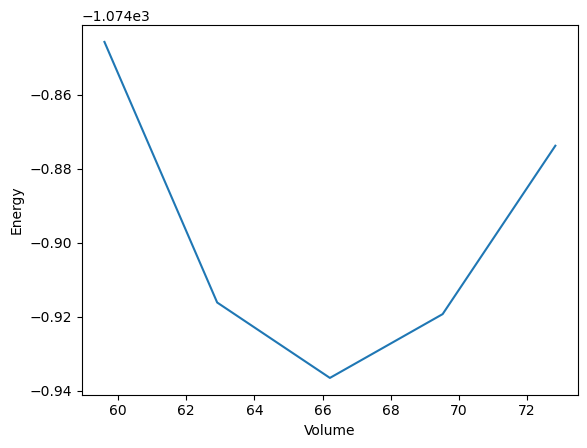

In [25]:
delayed_object_lst[-1].pull()